In [0]:
"""
  Librerias para la red neuronal - KERAS framework
"""
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import warnings

from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.core import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
# from keras.applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import _obtain_input_shape 
import keras.backend as K

CIFAR_TH_WEIGHTS_PATH = ''
CIFAR_TF_WEIGHTS_PATH = ''
CIFAR_TH_WEIGHTS_PATH_NO_TOP = ''
CIFAR_TF_WEIGHTS_PATH_NO_TOP = ''

IMAGENET_TH_WEIGHTS_PATH = ''
IMAGENET_TF_WEIGHTS_PATH = ''
IMAGENET_TH_WEIGHTS_PATH_NO_TOP = ''
IMAGENET_TF_WEIGHTS_PATH_NO_TOP = ''

In [0]:
"""
  ResNext Neural Network
  Desarrollo
"""

def ResNext(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
            include_top=True, weights=None, input_tensor=None,
            pooling=None, classes=10):

    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width,
                          weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights
    if weights == 'cifar10':
        if (depth == 29) and (cardinality == 8) and (width == 64):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels.h5',
                                            CIFAR_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels_no_top.h5',
                                            CIFAR_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels.h5',
                                            CIFAR_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels_no_top.h5',
                                            CIFAR_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def ResNextImageNet(input_shape=None, depth=[3, 4, 6, 3], cardinality=32, width=4, weight_decay=5e-4,
                    include_top=True, weights=None, input_tensor=None,
                    pooling=None, classes=1000):

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if type(depth) == int and (depth - 2) % 9 != 0:
        raise ValueError('Depth of the network must be such that (depth - 2)'
                         'should be divisible by 9.')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=112,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_res_next_imagenet(classes, img_input, include_top, depth, cardinality, width,
                                   weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnext')

    # load weights
    if weights == 'imagenet':
        if (depth == [3, 4, 6, 3]) and (cardinality == 32) and (width == 4):
            # Default parameters match. Weights for this model exist:

            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels.h5',
                                            IMAGENET_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_th_dim_ordering_th_kernels_no_top.h5',
                                            IMAGENET_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'tensorflow':
                    warnings.warn('You are using the TensorFlow backend, yet you '
                                  'are using the Theano '
                                  'image dimension ordering convention '
                                  '(`image_dim_ordering="th"`). '
                                  'For best performance, set '
                                  '`image_dim_ordering="tf"` in '
                                  'your Keras config '
                                  'at ~/.keras/keras.json.')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels.h5',
                                            IMAGENET_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_imagenet_32_4_tf_dim_ordering_tf_kernels_no_top.h5',
                                            IMAGENET_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                model.load_weights(weights_path)

                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


def __initial_conv_block(input, weight_decay=5e-4):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    return x


def __initial_conv_block_imagenet(input, weight_decay=5e-4):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    return x


def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    init = input
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    group_list = []

    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation('relu')(x)
        return x

    for c in range(cardinality):
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
        if K.image_data_format() == 'channels_last' else
        lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = Activation('relu')(x)

    return x


def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    init = input

    grouped_channels = int(filters / cardinality)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Check if input number of filters is same as 16 * k, else create convolution2d for this input
    if K.image_data_format() == 'channels_first':
        if init._keras_shape[1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init._keras_shape[-1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)

    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    x = add([init, x])
    x = Activation('relu')(x)

    return x


def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None):

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x


def __create_res_next_imagenet(nb_classes, img_input, include_top, depth, cardinality=32, width=4,
                               weight_decay=5e-4, pooling=None):

    if type(depth) is list or type(depth) is tuple:
        # If a list is provided, defer to user how many blocks are present
        N = list(depth)
    else:
        # Otherwise, default to 3 blocks each of default number of group convolution blocks
        N = [(depth - 2) // 9 for _ in range(3)]

    filters = cardinality * width
    filters_list = []

    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2  # double the size of the filters

    x = __initial_conv_block_imagenet(img_input, weight_decay)

    # block 1 (no pooling)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list
    filters_list = filters_list[1:]  # remove the first filter from the filter list

    # block 2 to N
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x

In [0]:
"""
  Librerias para el entrenamiento, dataset - cifar10
"""

from __future__ import print_function
from __future__ import division
  
import os
      
import numpy as np
import sklearn.metrics as metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

import matplotlib.pyplot as plt

Model created
Finished compiling
Building model...


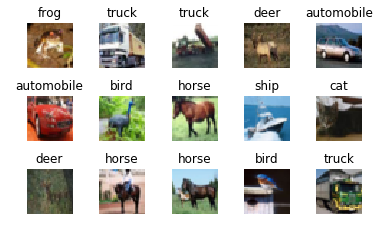

In [0]:
"""
  Cargar datos 
"""

batch_size = 100
nb_classes = 10
nb_epoch = 10

img_rows, img_cols = 32, 32
img_channels = 3

img_dim = (img_channels, img_rows, img_cols) if K.image_dim_ordering() == "th" else (img_rows, img_cols, img_channels)
depth = 29
cardinality = 8
width = 16

model = ResNext(img_dim, depth=depth, cardinality=cardinality, width=width, weights=None, classes=nb_classes)
print("Model created")

# model.summary()

optimizer = Adam(lr=1e-3)  # Using Adam instead of SGD to speed up training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
print("Finished compiling")
print("Building model...")

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')
testX = testX.astype('float32')

"""Normalizar entre 0 y 1"""
trainX /= 255.
testX /= 255.

Y_train = np_utils.to_categorical(trainY, nb_classes)
Y_test = np_utils.to_categorical(testY, nb_classes)

class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

def draw_img(i):
    im = trainX[i]
    c = trainY[i]
    plt.imshow(im)
    print(c)
    print(class_name[c[0]])
    plt.title("Class %d (%s)" % (c, class_name[c[0]]))
    plt.axis('on')

def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(32,32,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i][0]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
    if imfile:
        plt.savefig(imfile)

# draw_img(7)
draw_sample(trainX, trainY, 0, 3, 5)

In [0]:

generator = ImageDataGenerator(rotation_range=15,
                               width_shift_range=5./32,
                               height_shift_range=5./32,
                               horizontal_flip=True)

generator.fit(trainX, seed=0)

out_dir = "weights/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load model
weights_file = "weights/ResNext-8-64d.h5"

if os.path.exists(weights_file):
    model.load_weights(weights_file)
    print("Model loaded.")

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1),
                               cooldown=0, patience=10, min_lr=1e-6)

model_checkpoint = ModelCheckpoint(weights_file, monitor="val_acc", save_best_only=True,
                                   save_weights_only=True, mode='auto')

callbacks = [lr_reducer, model_checkpoint]

"""
  Entreno red
"""
model.fit_generator(generator.flow(trainX, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(trainX) // batch_size,
                    epochs=nb_epoch,
                    callbacks=callbacks,
                    validation_data=(testX, Y_test),
                    validation_steps=testX.shape[0] // batch_size, verbose=1)

Model loaded.
Epoch 1/10
500/500 [==============================] - 446s 893ms/step - loss: 1.1208 - acc: 0.7831 - val_loss: 1.3245 - val_acc: 0.7033
Epoch 2/10
500/500 [==============================] - 431s 862ms/step - loss: 1.0623 - acc: 0.7923 - val_loss: 1.4600 - val_acc: 0.6864
Epoch 3/10
500/500 [==============================] - 430s 861ms/step - loss: 1.0206 - acc: 0.8001 - val_loss: 2.4314 - val_acc: 0.5117
Epoch 4/10
500/500 [==============================] - 431s 861ms/step - loss: 0.9797 - acc: 0.8080 - val_loss: 1.4811 - val_acc: 0.6325
Epoch 5/10
500/500 [==============================] - 430s 860ms/step - loss: 0.9488 - acc: 0.8145 - val_loss: 2.6140 - val_acc: 0.5202
Epoch 6/10
500/500 [==============================] - 430s 860ms/step - loss: 0.9359 - acc: 0.8126 - val_loss: 1.2716 - val_acc: 0.7231
Epoch 7/10
500/500 [==============================] - 430s 859ms/step - loss: 0.8996 - acc: 0.8233 - val_loss: 1.2357 - val_acc: 0.7344
Epoch 8/10
500/500 [==============

10000
Accuracy :  68.10000000000001
Error :  31.89999999999999


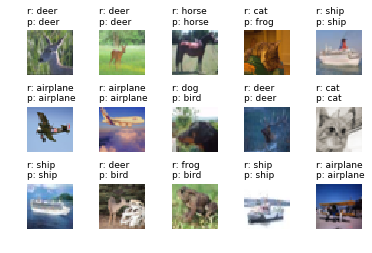

In [0]:
yPreds = model.predict(testX)
yPred = np.argmax(yPreds, axis=1)
yTrue = testY

import random
test_size = len(testY)
print(test_size)

for i in range(0,15):
    plt.subplot(3, 5, i+1)
    idx = random.randint(0,test_size)
    plt.imshow(testX[idx], cmap='gnuplot2')
    plt.title("r: %s\np: %s" % (class_name[yTrue[idx][0]], class_name[yPred[idx]]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

accuracy = metrics.accuracy_score(yTrue, yPred) * 100
error = 100 - accuracy
print("Accuracy : ", accuracy)
print("Error : ", error)